In [1]:
using ReinforcementLearning, ReinforcementLearningEnvironments

┌ Info: Precompiling ReinforcementLearning [158674fc-8238-5cab-b5ba-03dfc80d1318]
└ @ Base loading.jl:1264


In [2]:
using RLIntro, RLIntro.BlackJack

In [3]:
env = BlackJackEnv(;init=(BlackJack.Hands(13, [1, 2], true), BlackJack.Hands(2, [2], false)))

ns, na = length(observation_space(env)), length(action_space(env))

(220, 2)

In [4]:
init_state = get_state(observe(env))

27

In [5]:
const GOLD_VAL = -0.27726

-0.27726

In [6]:
stick_action = findall(x -> x == :stick, BlackJack.ACTIONS)[]

table = fill(1, size(BlackJack.INDS)...)
table[:, 10:11, :] .= stick_action
table = reshape(table, :);

π_behavior = TabularRandomPolicy(fill(0.5, length(table), na))

TabularRandomPolicy([0.5 0.5; 0.5 0.5; … ; 0.5 0.5; 0.5 0.5])

In [7]:
struct StoreMSE <: AbstractHook
    mse::Vector{Float64}
end

StoreMSE() = StoreMSE([])

(f::StoreMSE)(::PostEpisodeStage, agent, env, obs) = push!(f.mse, (GOLD_VAL - agent.π.π_target.learner.approximator(init_state))^2)


In [8]:
function mse_of_ordinary_sampling()
    agent = Agent(
        π=OffPolicy(
            VBasedPolicy(
                learner=MonteCarloLearner(
                    TabularVApproximator(ns),
                    kind=FIRST_VISIT,
                    sampling=ORDINARY_IMPORTANCE_SAMPLING
                    ),
                f= TabularDeterministicPolicy(table=table,nactions=na)
                ),
            π_behavior
            ),
        buffer=episode_RTSA_buffer()
    )
    hook = StoreMSE([])
    run(agent, env, StopAfterEpisode(10000);hook=hook)
    hook.mse
end

mse_of_ordinary_sampling (generic function with 1 method)

In [9]:
function mse_of_weighted_sampling()
    agent = Agent(
        π=OffPolicy(
            VBasedPolicy(
                learner=MonteCarloLearner(
                    TabularVApproximator(ns),
                    kind=FIRST_VISIT,
                    sampling=WEIGHTED_IMPORTANCE_SAMPLING,
                    returns=(CachedSum(), CachedSum())
                    ),
                f= TabularDeterministicPolicy(table=table,nactions=na)
                ),
            π_behavior
            ),
        buffer=episode_RTSA_buffer()
    )
    hook = StoreMSE([])
    run(agent, env, StopAfterEpisode(10000);hook=hook)
    hook.mse
end

mse_of_weighted_sampling (generic function with 1 method)

Progress:   0%|                                         |  ETA: N/A
4m  TRAINING/EPISODE:  -1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  TRAINING/EPISODE:  5627


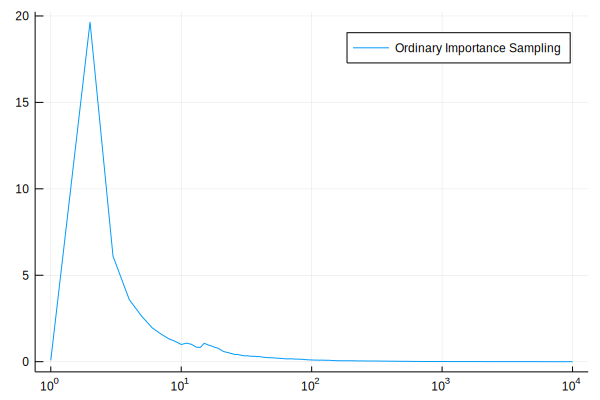

In [10]:
using Plots, StatsBase

plot(mean((mse_of_ordinary_sampling() for _ in 1:100)); xscale=:log10, label="Ordinary Importance Sampling")

Progress:   0%|                                         |  ETA: N/A
4m  TRAINING/EPISODE:  -1
Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:00
4m  TRAINING/EPISODE:  4388
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  5622
Progress:  45%|██████████████████▎                      |  ETA: 0:00:00
4m  TRAINING/EPISODE:  2515
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  5651


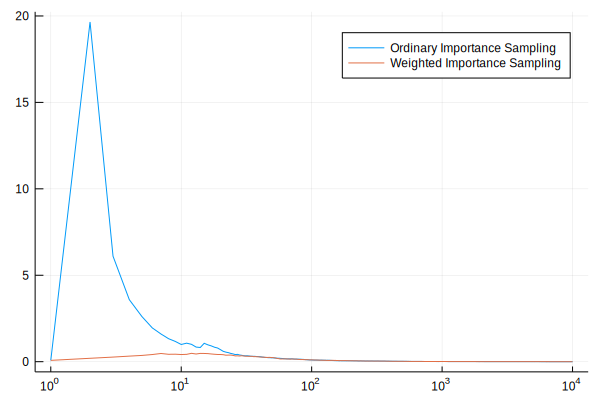

In [11]:
plot!(mean((mse_of_weighted_sampling() for _ in 1:100)); xscale=:log10, label="Weighted Importance Sampling")